In [28]:
# print the current working directory
import os
print(os.getcwd())


c:\Users\rquax1\Repositories\jointpmf_package\src\jointpmf\notebooks


In [29]:
# print pythonpath
print(os.getenv('PYTHONPATH'))

C:\Users\rquax1\Repositories\A3;C:\Users\rquax1\Repositories\jointpmf_package\src;C:\Users\rquax1\Repositories\netsy;


In [30]:
import numpy as np
from funcy import flatten
import copy

import jointpmf as jp
# import jointpmf.direct_srv as ds

# import networkx as netx  # IMPORTANT: if you import networkx then don't use `nx`! ALready used as variable name below.

import itertools

import importlib
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from scipy.optimize import minimize

from funcy import flatten
import time
import pickle

from typing import Iterable, Sequence, Any

# Append an SRV using all different methods

We will compare quality and time taken.

In [31]:
numvalues = 3
chase_violations = 100
maxiter = 1000

In [32]:
# print the current working directory
import os
print(os.getcwd())


c:\Users\rquax1\Repositories\jointpmf_package\src\jointpmf\notebooks


In [33]:
# print pythonpath
print(os.getenv('PYTHONPATH'))

C:\Users\rquax1\Repositories\A3;C:\Users\rquax1\Repositories\jointpmf_package\src;C:\Users\rquax1\Repositories\netsy;


In [34]:
df_results = pd.DataFrame(columns=['BN', 'method', 'time_taken', 'violation', 'total_MI', 'individual_MIs', 'syninfo_lb', 'ps'])

In [38]:
# methods = ['RBF', 'direct+RBF', 'direct+SLSQP', 'SLSQP', 'direct+chase', 'direct', 
#            'direct/unbounded', 'direct/closest_to_1', 'direct/closest_to_1_above_1']   # all possible methods
methods = ['direct+chase', 'direct[joint]', 'direct[marginal]', 
           'direct/unbounded', 'direct/closest_to_1', 'direct/closest_to_1_above_1']

ntrials = 20

verbose = 0

for trial in range(ntrials):
    if verbose > 0:
        print(f'=== Trial {trial + 1}/{ntrials} ===')

    bn_test = jp.BayesianNetwork()  # make a BN with the two input variables to which we will append a synergistic variable
    bn_test.append_independent_variable(numvalues=numvalues)
    bn_test.append_independent_variable(numvalues=numvalues)

    # serialized BN object, to be able to reconstruct later if needed
    # serialized_bn = pickle.dumps(bn_test)
    serialized_bn = trial  # actually, just use the trial number as the identifier: the BN can be reconstructed from 'ps'

    # marginal probabilities per input
    ps = np.array([bn_test.marginal_probabilities(xix) for xix in range(len(bn_test))], dtype=float)

    bns = [bn_test]  # make `len(methods)` copies of `bn_test` to be used in the loop below (fair comparison)
    for _ in methods[:-1]:
        bns.append(copy.deepcopy(bn_test))

    for bn, method in zip(bns, methods):
        if verbose > 1:
            print (f'--- Using {method=}:')

        time_before = time.time()
        if method == 'SLSQP':
            bn.append_synergistic_variable_using_constraint_based_optimization([0, 1], numvalues, start_from_direct_srv=False, 
                                                                               verbose=0, maxiter=maxiter)
        elif method == 'RBF':
            bn.append_synergistic_variable([0, 1], numvalues, max_evals=maxiter)
        elif method == 'direct+RBF':
            bn.append_synergistic_variable([0, 1], numvalues, max_evals=maxiter, start_from_direct_srv=True)
        elif method == 'direct[joint]':
            bn.append_direct_synergistic_variable([0, 1], numvalues=numvalues, verbose=0, direct_srv_args={'method': 'joint', 'on_violation': 'continue'})
        elif method == 'direct[marginal]':
            bn.append_direct_synergistic_variable([0, 1], numvalues=numvalues, verbose=0, direct_srv_args={'method': 'marginal', 'on_violation': 'continue'})
        elif method == 'direct/unbounded':
            bn.append_direct_synergistic_variable([0, 1], numvalues, verbose=0, direct_srv_args={'on_violation': 'continue', 'method_ordering': 'unbounded'})
        elif method == 'direct/closest_to_1':
            bn.append_direct_synergistic_variable([0, 1], numvalues, verbose=0, direct_srv_args={'on_violation': 'continue', 'method_ordering': 'closest_to_1'})
        elif method == 'direct/closest_to_1_above_1':
            bn.append_direct_synergistic_variable([0, 1], numvalues, verbose=0, direct_srv_args={'on_violation': 'continue', 'method_ordering': 'closest_to_1_above_1'})
        elif method == 'direct+chase':
            bn.append_direct_synergistic_variable([0, 1], numvalues, verbose=0, direct_srv_args={'on_violation': 'continue', 'chase_violations': chase_violations})
        elif method == 'direct+SLSQP':
            bn.append_synergistic_variable_using_constraint_based_optimization([0, 1], numvalues, start_from_direct_srv=True, 
                                                                               verbose=0, maxiter=maxiter)
        else:
            raise NotImplementedError(f'Unknown method: {method}')
        time_taken = time.time() - time_before
        
        if verbose > 1:
            print(f'time taken (wall clock): {time_taken:.2f} seconds')

        violation = bn.constraint_violation_srv([0, 1], len(bn) - 1)
        totmi = bn.mutual_information(list(range(len(bn) - 1)), [len(bn) - 1])
        indivmis = [bn.mutual_information([xix], [len(bn) - 1]) for xix in range(len(bn) - 1)]
        syninfo_lb = bn.wms([0, 1], [len(bn) - 1])

        df_results.loc[len(df_results)] = {'BN': serialized_bn, 'method': method, 'time_taken': time_taken, 'violation': violation, 
                                           'total_MI': totmi, 'individual_MIs': indivmis, 'syninfo_lb': syninfo_lb, 'ps': ps}

        if verbose > 1:
            print(f'total MI: {totmi}  (individual MIs: {indivmis})')
            print(f'violation of SRV constraints: {violation}')

In [39]:
df_results.head()

BN            method  time_taken     violation  total_MI  \
0   0      direct+chase    0.024852  3.184157e-16  0.058356   
1   0      direct+chase    0.055031  2.777724e-16  0.156126   
2   0     direct[joint]    0.016757  3.005310e-01  0.167911   
3   0  direct[marginal]    0.017447  1.774286e-16  0.162327   
4   0  direct/unbounded    0.017396  3.005310e-01  0.167911   

                                     individual_MIs  syninfo_lb  \
0  [4.440892098500626e-16, -1.6653345369377348e-16]    0.058356   
1                                        [0.0, 0.0]    0.156126   
2    [9.836358865200623e-07, 0.0016919306172882287]    0.166218   
3                                        [0.0, 0.0]    0.162327   
4    [9.836358865200623e-07, 0.0016919306172882287]    0.166218   

                                                  ps  
0  [[0.5264550980311199, 0.31160413170863066, 0.1...  
1  [[0.42323412095801205, 0.554756356783222, 0.02...  
2  [[0.42323412095801205, 0.554756356783222, 0.02...  
3  [[0.42323412095801205, 0.554756356783222, 0.02...  
4  [[0.42323412095801205, 0.554756356783222, 0.02...

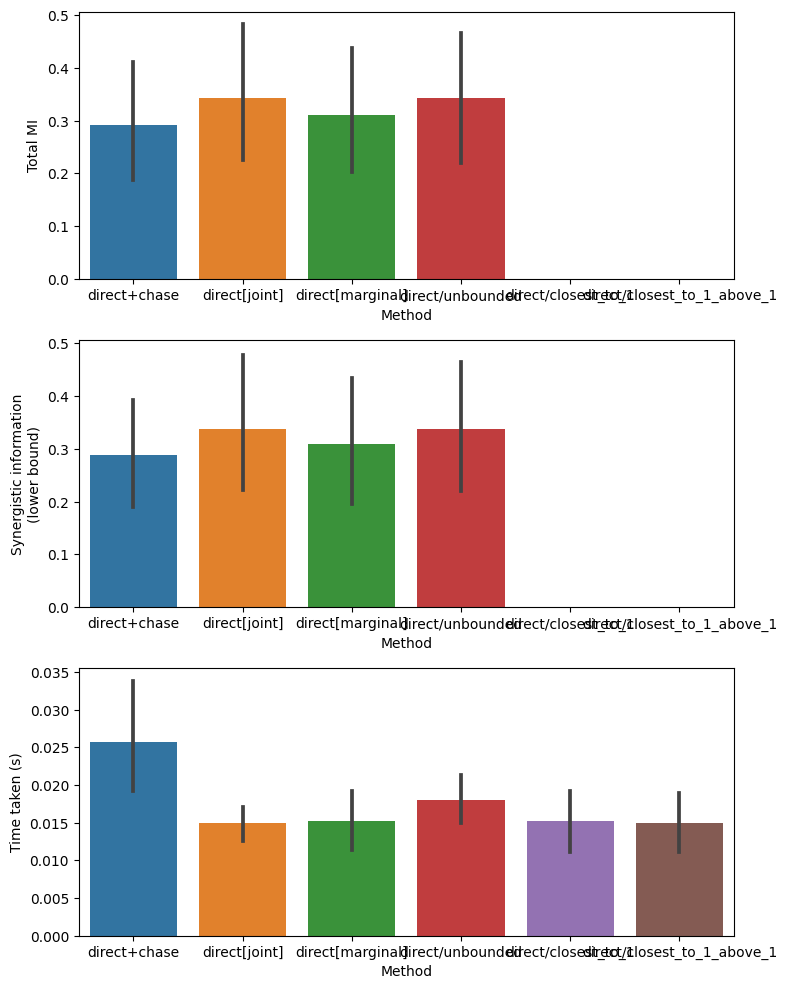

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(3, 1, figsize=(8, 10))

# Plot the Total MI violin plot
# Plot the Total MI bar plot
sns.barplot(data=df_results, x='method', y='total_MI', ax=ax[0])
# ax[0].set_title('Total MI by Method')
ax[0].set_xlabel('Method')
ax[0].set_ylabel('Total MI')

# Plot the Violation bar plot
sns.barplot(data=df_results, x='method', y='syninfo_lb', ax=ax[1])
# ax[1].set_title('Violation by Method')
ax[1].set_xlabel('Method')
ax[1].set_ylabel('Synergistic information\n(lower bound)')
ax[1].set_ylim(ax[0].get_ylim())

# Plot the time taken plot
sns.barplot(data=df_results, x='method', y='time_taken', ax=ax[2])
ax[2].set_xlabel('Method')
ax[2].set_ylabel('Time taken (s)')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()


In [41]:
transformed_df = df_results.pivot(index='BN', columns='method', values=['time_taken', 'violation', 'total_MI', 'syninfo_lb'])

transformed_df.head()

ValueError: Index contains duplicate entries, cannot reshape

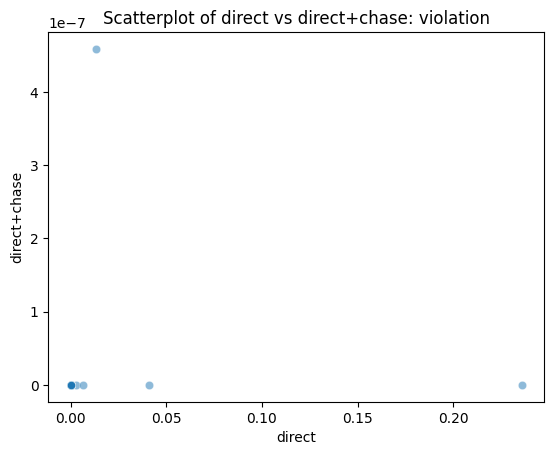

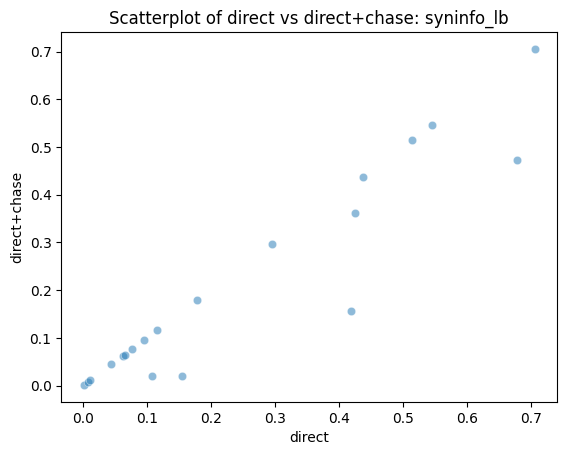

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

for result_type in ['violation', 'syninfo_lb']:
    # Create a scatterplot
    sns.scatterplot(data=transformed_df[result_type], x='direct', y='direct+chase', alpha=0.5)

    # Set the title and labels
    plt.title('Scatterplot of direct vs direct+chase: ' + result_type)
    plt.xlabel('direct')
    plt.ylabel('direct+chase')

    # Show the plot
    plt.show()